In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Google Drive'ı bağla (veri setine erişim için)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
IMG_SIZE = 224
DATA_DIR = "/content/drive/MyDrive/rice_leafs_dataset"
CATEGORIES = os.listdir(DATA_DIR)

X = []  # Görüntüler
y = []  # Etiketler

In [4]:
CATEGORIES

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

In [5]:
# Her sınıf klasörünü gezerek görselleri oku ve boyutlandır
for idx, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category)
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(idx)
        except:
            print(f"Hata oluştu: {img_path}")

In [6]:
X = np.array(X) / 255.0  # Normalize
y = np.array(y)

In [7]:
# Etiket isimlerini kaydet
label_map = {i: cat for i, cat in enumerate(CATEGORIES)}
print(label_map)

{0: 'Bacterialblight', 1: 'Blast', 2: 'Brownspot', 3: 'Tungro'}


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim/Doğrulama için veri artırma ayarları
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # %80 - %20 test için
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Eğitim verisi oluşturucu
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/rice_leafs_dataset',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Doğrulama verisi oluşturucu
val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/rice_leafs_dataset',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False # False değeri ile aynı test verilerini tutuyoruz. Daha sonra metrik tutarken ve hesaplarken hataya sebebiyet vermemeli
)


Found 4747 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.


In [9]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator
        self.accuracy = []
        self.precision = []
        self.recall = []
        self.f1 = []
        self.y_true = val_generator.classes

    def on_epoch_end(self, epoch, logs=None):
        steps = int(np.ceil(self.val_generator.samples / self.val_generator.batch_size))
        y_pred_probs = self.model.predict(self.val_generator, steps=steps, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Performans metriklerini hesaplıyoruz.
        acc = accuracy_score(self.y_true, y_pred)
        prec = precision_score(self.y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(self.y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(self.y_true, y_pred, average='weighted', zero_division=0)

        self.accuracy.append(acc)
        self.precision.append(prec)
        self.recall.append(rec)
        self.f1.append(f1)

        print(f"Epoch {epoch+1} — val_acc: {acc:.4f} val_prec: {prec:.4f} val_rec: {rec:.4f} val_f1: {f1:.4f}")


In [51]:
from tensorflow.keras.applications import MobileNet, VGG16, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model(base_model_class):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False # Önceden eğitilmiş ağırlıklar dondurulur. Eğitimi hızlandırmak amacı ile.

    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Özellik haritasını düzleştirir ve her filtre için ortalama alır
    x = Dense(512, activation='relu')(x) # Tam bağlantılı katman, 512 nöron, ReLU aktivasyon
    output = Dense(4, activation='softmax')(x) # 4 sınıf için çıktı, softmax ile olasılıklar
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelleri oluştur
mobilenet_model = create_model(MobileNet)
vgg16_model = create_model(VGG16)
xception_model = create_model(Xception)
vgg19_model = create_model(VGG19)


In [11]:
# Callback'leri tanımla
mobilenet_metrics = MetricsCallback(val_generator)
vgg16_metrics = MetricsCallback(val_generator)
xception_metrics = MetricsCallback(val_generator)
vgg19_metrics = MetricsCallback(val_generator)

In [12]:
%%time
print("\n MobileNet Model")
mobilenet_history = mobilenet_model.fit(train_generator, validation_data=val_generator, epochs=16, callbacks=[mobilenet_metrics])


 MobileNet Model


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7299 - loss: 0.7107Epoch 1 — val_acc: 0.9350 val_prec: 0.9362 val_rec: 0.9350 val_f1: 0.9350
149/149 ━━━━━━━━━━━━━━━━━━━━ 114s 695ms/step - accuracy: 0.7307 - loss: 0.7089 - val_accuracy: 0.9325 - val_loss: 0.2217
Epoch 2/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9544 - loss: 0.1760Epoch 2 — val_acc: 0.9722 val_prec: 0.9724 val_rec: 0.9722 val_f1: 0.9722
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 596ms/step - accuracy: 0.9544 - loss: 0.1758 - val_accuracy: 0.9738 - val_loss: 0.1192
Epoch 3/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9747 - loss: 0.1049Epoch 3 — val_acc: 0.9781 val_prec: 0.9781 val_rec: 0.9781 val_f1: 0.9780
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 597ms/step - accuracy: 0.9747 - loss: 0.1048 - val_accuracy: 0.9797 - val_loss: 0.0816
Epoch 4/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9902 - loss: 0.0616Epoch 4 — val_acc: 0.9907 val_prec: 0.9908 val_rec: 0.9907 val_f1: 0.

In [13]:
%%time
print("\n VGG16 Model")
vgg16_history = vgg16_model.fit(train_generator, validation_data=val_generator, epochs=16, callbacks=[vgg16_metrics])


 VGG16 Model
Epoch 1/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5186 - loss: 1.2092Epoch 1 — val_acc: 0.7342 val_prec: 0.7383 val_rec: 0.7342 val_f1: 0.7316
149/149 ━━━━━━━━━━━━━━━━━━━━ 101s 639ms/step - accuracy: 0.5194 - loss: 1.2083 - val_accuracy: 0.7300 - val_loss: 0.8913
Epoch 2/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7564 - loss: 0.7850Epoch 2 — val_acc: 0.7511 val_prec: 0.7603 val_rec: 0.7511 val_f1: 0.7450
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 598ms/step - accuracy: 0.7564 - loss: 0.7848 - val_accuracy: 0.7553 - val_loss: 0.7072
Epoch 3/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7830 - loss: 0.6404Epoch 3 — val_acc: 0.7738 val_prec: 0.7723 val_rec: 0.7738 val_f1: 0.7708
149/149 ━━━━━━━━━━━━━━━━━━━━ 88s 594ms/step - accuracy: 0.7831 - loss: 0.6402 - val_accuracy: 0.7873 - val_loss: 0.6008
Epoch 4/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8149 - loss: 0.5456Epoch 4 — val_acc: 0.7907 val_prec: 0.7914 val_rec: 0.7

In [39]:
%%time
print("\n Xception Model")
xception_history = xception_model.fit(train_generator, validation_data=val_generator, epochs=16, callbacks=[xception_metrics])


 Xception Model
Epoch 1/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9054 - loss: 0.2855Epoch 1 — val_acc: 0.9392 val_prec: 0.9394 val_rec: 0.9392 val_f1: 0.9392
149/149 ━━━━━━━━━━━━━━━━━━━━ 111s 680ms/step - accuracy: 0.9056 - loss: 0.2853 - val_accuracy: 0.9401 - val_loss: 0.2104
Epoch 2/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9458 - loss: 0.1859Epoch 2 — val_acc: 0.9494 val_prec: 0.9536 val_rec: 0.9494 val_f1: 0.9498
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 596ms/step - accuracy: 0.9459 - loss: 0.1858 - val_accuracy: 0.9460 - val_loss: 0.1744
Epoch 3/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9582 - loss: 0.1401Epoch 3 — val_acc: 0.9586 val_prec: 0.9591 val_rec: 0.9586 val_f1: 0.9587
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 600ms/step - accuracy: 0.9582 - loss: 0.1401 - val_accuracy: 0.9595 - val_loss: 0.1311
Epoch 4/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9684 - loss: 0.1169Epoch 4 — val_acc: 0.9764 val_prec: 0.9765 val_rec: 

In [15]:
%%time
print("\n VGG19 Model")
vgg19_history = vgg19_model.fit(train_generator, validation_data=val_generator, epochs=16, callbacks=[vgg19_metrics])


 VGG19 Model
Epoch 1/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4588 - loss: 1.2742Epoch 1 — val_acc: 0.7224 val_prec: 0.7265 val_rec: 0.7224 val_f1: 0.7162
149/149 ━━━━━━━━━━━━━━━━━━━━ 95s 619ms/step - accuracy: 0.4596 - loss: 1.2732 - val_accuracy: 0.7105 - val_loss: 0.9178
Epoch 2/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7260 - loss: 0.8672Epoch 2 — val_acc: 0.7063 val_prec: 0.7085 val_rec: 0.7063 val_f1: 0.6960
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 595ms/step - accuracy: 0.7260 - loss: 0.8670 - val_accuracy: 0.7266 - val_loss: 0.7794
Epoch 3/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7311 - loss: 0.7635Epoch 3 — val_acc: 0.7443 val_prec: 0.7498 val_rec: 0.7443 val_f1: 0.7400
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 595ms/step - accuracy: 0.7312 - loss: 0.7632 - val_accuracy: 0.7376 - val_loss: 0.6972
Epoch 4/16
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7682 - loss: 0.6594Epoch 4 — val_acc: 0.7586 val_prec: 0.7646 val_rec: 0.75

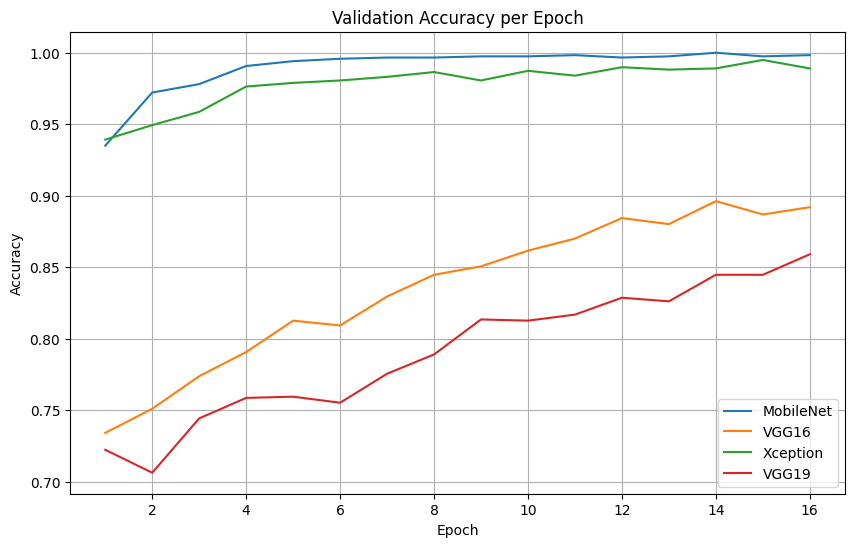

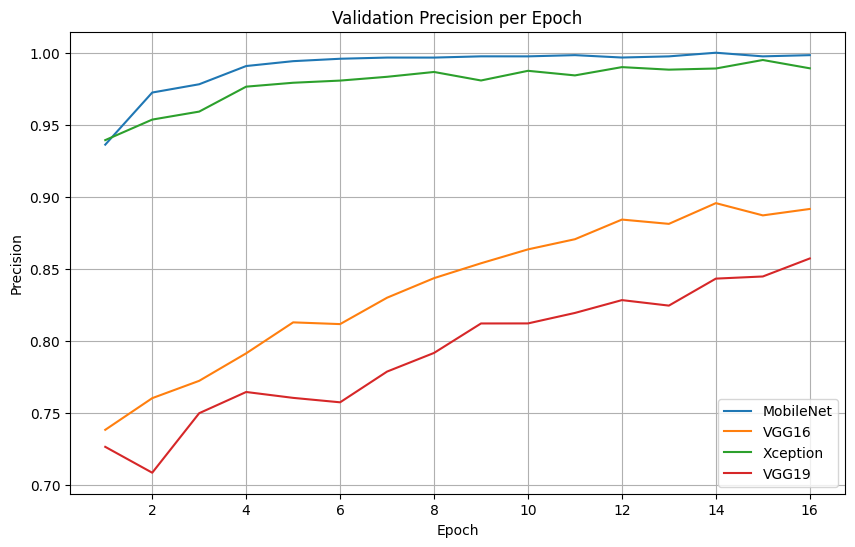

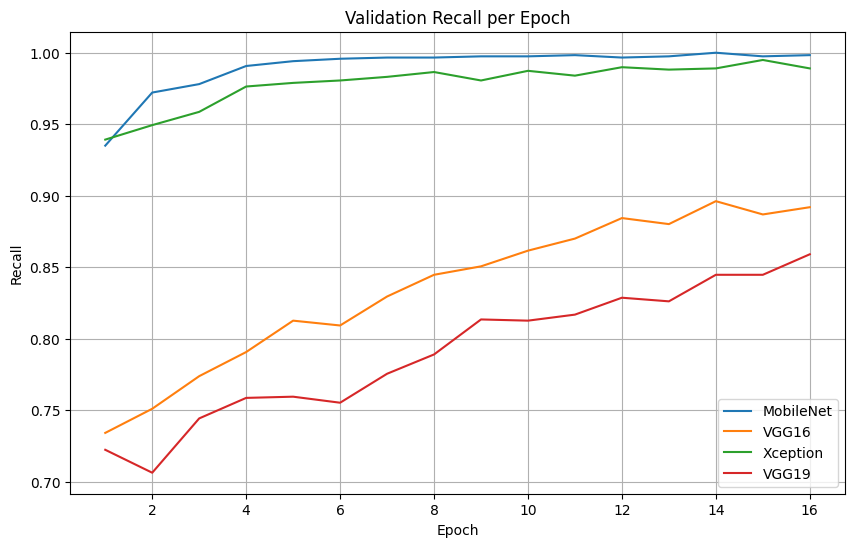

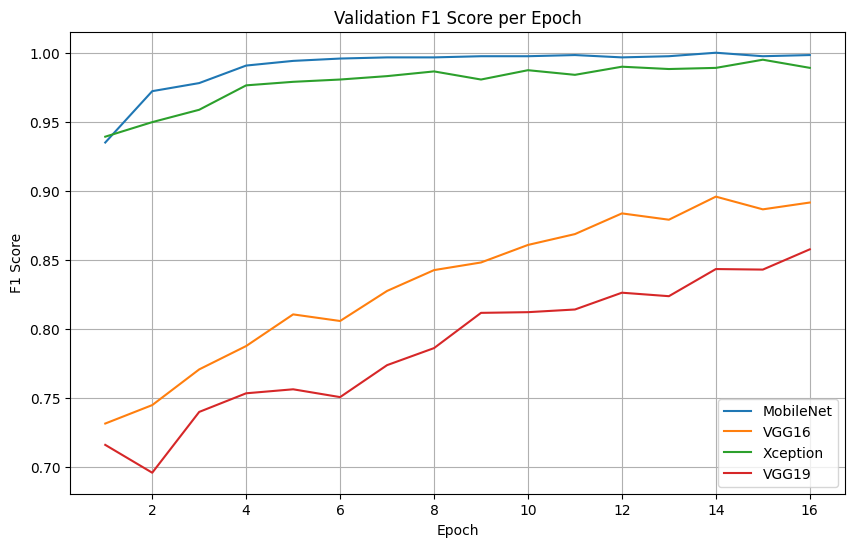

In [41]:
import matplotlib.pyplot as plt

def plot_metrics_all_models(models_metrics, metric_name, title, ylabel):
    """
    models_metrics: dict, {model_name: MetricsCallback instance}
    metric_name: str, 'accuracy', 'precision', 'recall', 'f1'
    """
    plt.figure(figsize=(10, 6))
    for model_name, metrics in models_metrics.items():
        values = getattr(metrics, metric_name)
        epochs = range(1, len(values) + 1)
        plt.plot(epochs, values, label=model_name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

models_metrics = {
    'MobileNet': mobilenet_metrics,
    'VGG16': vgg16_metrics,
    'Xception': xception_metrics,
    'VGG19': vgg19_metrics
}

# Validation metriklerini çiz
plot_metrics_all_models(models_metrics, 'accuracy', 'Validation Accuracy per Epoch', 'Accuracy')
plot_metrics_all_models(models_metrics, 'precision', 'Validation Precision per Epoch', 'Precision')
plot_metrics_all_models(models_metrics, 'recall', 'Validation Recall per Epoch', 'Recall')
plot_metrics_all_models(models_metrics, 'f1', 'Validation F1 Score per Epoch', 'F1 Score')


In [48]:
# Eğitim ve doğrulama seti metriklerini çizmek için fonksiyonlar
def plot_train_metrics_all_models(models_history, metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    for model_name, history in models_history.items():
        values = history.history.get(metric_name)
        if values:
            epochs = range(1, len(values) + 1)
            plt.plot(epochs, values, label=model_name)
    plt.title(f'{title} (Train)')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_val_metrics_all_models(models_history, metric_name, title, ylabel):
    plt.figure(figsize=(10, 6))
    for model_name, history in models_history.items():
        val_values = history.history.get(f'val_{metric_name}')
        if val_values:
            epochs = range(1, len(val_values) + 1)
            plt.plot(epochs, val_values, label=model_name)
    plt.title(f'{title} (Validation)')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

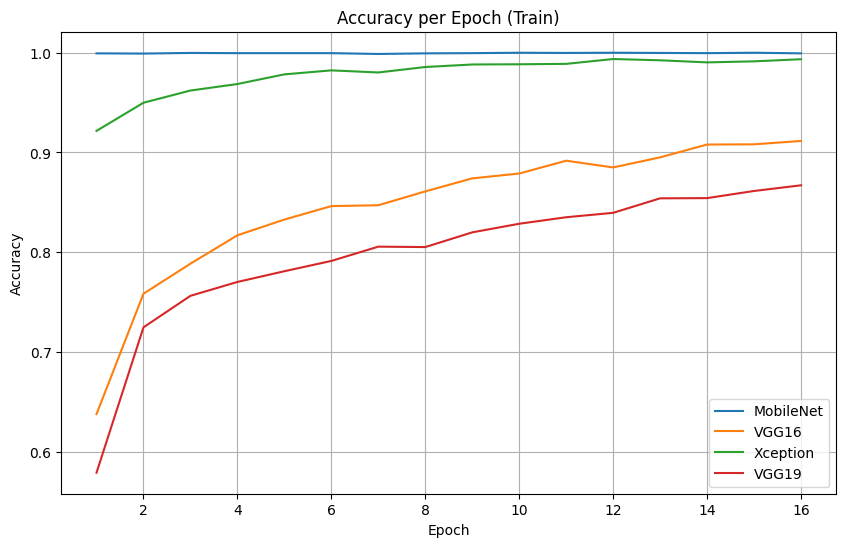

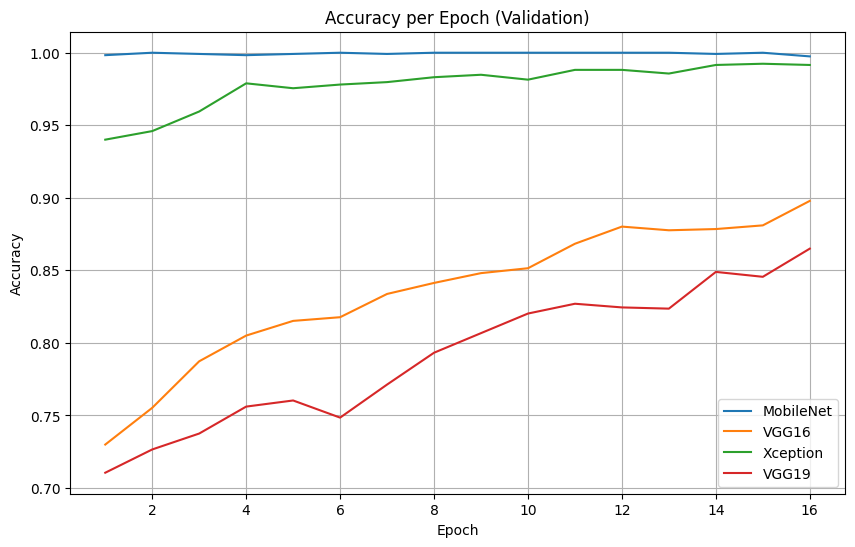

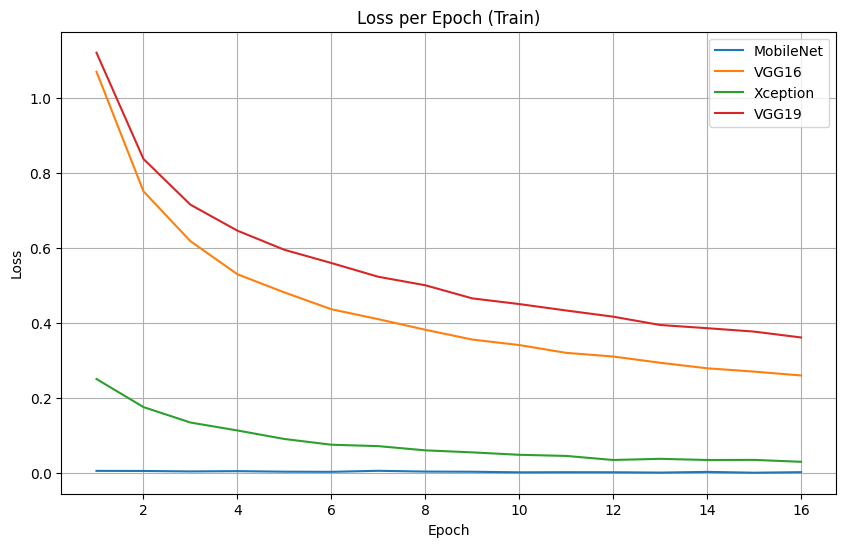

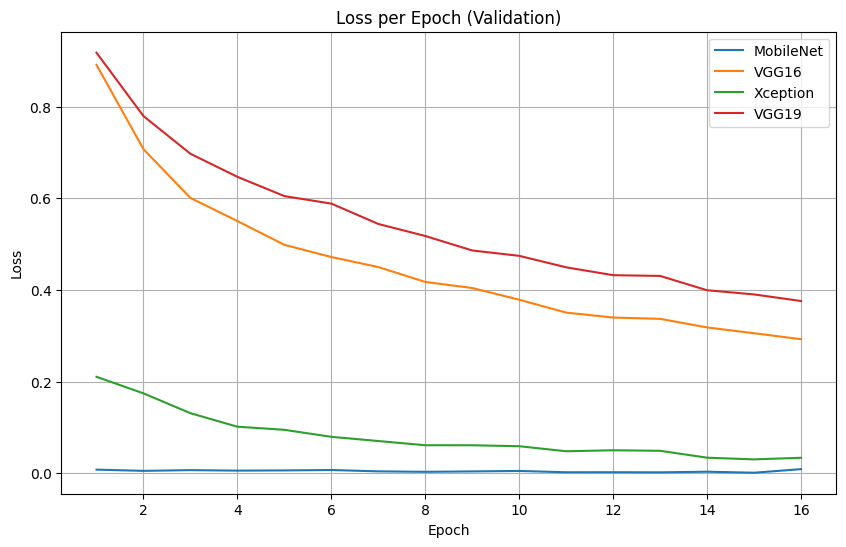

In [49]:
models_history = {
    'MobileNet': mobilenet_history,
    'VGG16': vgg16_history,
    'Xception': xception_history,
    'VGG19': vgg19_history
}

plot_train_metrics_all_models(models_history, 'accuracy', 'Accuracy per Epoch', 'Accuracy')
plot_val_metrics_all_models(models_history, 'accuracy', 'Accuracy per Epoch', 'Accuracy')

plot_train_metrics_all_models(models_history, 'loss', 'Loss per Epoch', 'Loss')
plot_val_metrics_all_models(models_history, 'loss', 'Loss per Epoch', 'Loss')

In [50]:
import pandas as pd

results = {
    'Model': ['MobileNet', 'VGG16', 'Xception', 'VGG19'],
    'Accuracy': [mobilenet_metrics.accuracy[-1], vgg16_metrics.accuracy[-1], xception_metrics.accuracy[-1], vgg19_metrics.accuracy[-1]],
    'Precision': [mobilenet_metrics.precision[-1], vgg16_metrics.precision[-1], xception_metrics.precision[-1], vgg19_metrics.precision[-1]],
    'Recall': [mobilenet_metrics.recall[-1], vgg16_metrics.recall[-1], xception_metrics.recall[-1], vgg19_metrics.recall[-1]],
    'F1-Score': [mobilenet_metrics.f1[-1], vgg16_metrics.f1[-1], xception_metrics.f1[-1], vgg19_metrics.f1[-1]]
}

# Performans karşılaştırma tablosu
df_results = pd.DataFrame(results)
print(df_results)

       Model  Accuracy  Precision    Recall  F1-Score
0  MobileNet  0.998312   0.998315  0.998312  0.998312
1      VGG16  0.891983   0.891576  0.891983  0.891583
2   Xception  0.989030   0.989180  0.989030  0.989051
3      VGG19  0.859072   0.857220  0.859072  0.857707
